In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import shutil
import tensorflow as tf
from tensorflow import keras
from patchify import patchify, unpatchify
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import EarlyStopping

from functions import load_data, displaying_images, matching_masks, padder, roi_image, preprocess_data, f1, iou, simple_unet_model, loss_plot, accuracy_plot, predict_all

2024-01-24 23:15:09.066231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 23:15:09.066269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 23:15:09.067265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 23:15:09.073589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Taking the necessary paths.

In [2]:
train_folder =  'Dataset/train'
test_folder = 'Dataset/test'
masks_folder = 'Masks'

train_masks_folder = 'train_masks'
test_masks_folder = 'test_masks'
images_with_no_masks_folder = 'images_with_no_masks'

Loading the images and the masks, which contain root in them ('root' is set as default type)

In [3]:
images_train = load_data(train_folder, type='.png')
images_test = load_data(test_folder, type='.png')
masks_train = load_data(train_masks_folder, type='.tif')
masks_test = load_data(test_masks_folder, type='.tif')

Preprocessing the data by cropping it, padding, patching, reshaping, converting to numpy array and normalizing (only the images were normalized, because the masks were already)

In [4]:
patch_size = 256

X_train, y_train = preprocess_data(images_train, masks_train, patch_size)
X_test, y_test = preprocess_data(images_test, masks_test, patch_size)

Cheching the shape of the data

In [5]:
print(f"Shape of train images: ", X_train.shape)
print(f"Shape of test images: ", X_test.shape)
print(f"Shape of train root masks: ", y_train.shape)
print(f"Shape of test root masks: ", y_test.shape)

Shape of train images:  (7502, 256, 256, 1)
Shape of test images:  (2541, 256, 256, 1)
Shape of train root masks:  (7502, 256, 256, 1)
Shape of test root masks:  (2541, 256, 256, 1)


1 class for the model, because it is binary

In [6]:
n_classes = 1

Defining the model as it takes the number of classes, sizes (in our cases the size of pathes, which is 256 by 256) and the number of channels

In [7]:
model = simple_unet_model(n_classes, patch_size, patch_size, 1)

2024-01-24 23:16:27.609024: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-24 23:16:27.648324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13708 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-01-24 23:16:27.648910: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-24 23:16:27.784045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1803 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6
2024-01-24 23:16:27.784467: W tensorflow/core/common_runt

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

Training with earlystopping on validation loss with patience 2 and batch_size of 16, 50 epochs. For validation data was choosen the test data.

In [8]:
cb = EarlyStopping(monitor='val_loss',
                   patience=2,
                   restore_best_weights='True',
                   mode='min')

history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[cb])

Epoch 1/50


2024-01-24 23:16:39.466713: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-24 23:16:43.403924: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-01-24 23:16:51.922213: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdcbd1d9940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 23:16:51.922291: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-24 23:16:51.922306: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-24 23:16:51.922334: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capa

469/469 [==============================] - 119s 166ms/step - loss: 0.0350 - accuracy: 0.9916 - f1: 0.0798 - iou: 0.6610 - val_loss: 0.0158 - val_accuracy: 0.9949 - val_f1: 0.2906 - val_iou: 0.6269
Epoch 2/50
469/469 [==============================] - 45s 96ms/step - loss: 0.0136 - accuracy: 0.9951 - f1: 0.6564 - iou: 0.6425 - val_loss: 0.0098 - val_accuracy: 0.9963 - val_f1: 0.3483 - val_iou: 0.7064
Epoch 3/50
469/469 [==============================] - 45s 96ms/step - loss: 0.0099 - accuracy: 0.9962 - f1: 0.7440 - iou: 0.7715 - val_loss: 0.0090 - val_accuracy: 0.9966 - val_f1: 0.3544 - val_iou: 0.8457
Epoch 4/50
469/469 [==============================] - 45s 96ms/step - loss: 0.0086 - accuracy: 0.9966 - f1: 0.7742 - iou: 0.8287 - val_loss: 0.0082 - val_accuracy: 0.9968 - val_f1: 0.3603 - val_iou: 0.8744
Epoch 5/50
469/469 [==============================] - 45s 95ms/step - loss: 0.0085 - accuracy: 0.9967 - f1: 0.7818 - iou: 0.8399 - val_loss: 0.0088 - val_accuracy: 0.9968 - val_f1: 0.35

The model performed well as it met the clients requirement of iou over 0.5. The other evaluation metrics are also well as the we have low loss and high accuracy.

In [9]:
loss, acc, f1, iou = model.evaluate(X_test, y_test, batch_size=8)

318/318 [==============================] - 15s 26ms/step - loss: 0.0081 - accuracy: 0.9968 - f1: 0.3123 - iou: 0.7729


Saving the model so it can be used in the other tasks.

In [10]:
model.save('root_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Visualizing the loss and the accuracy.

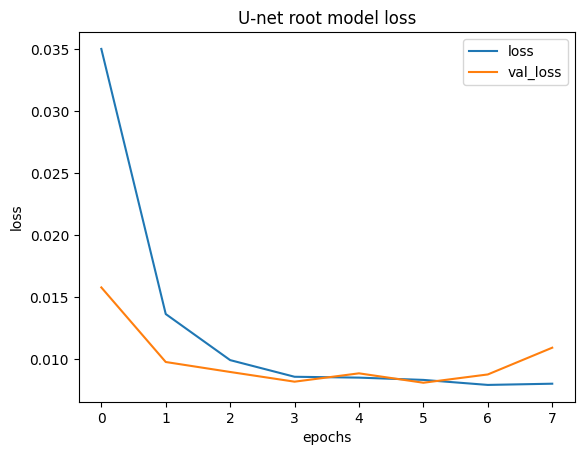

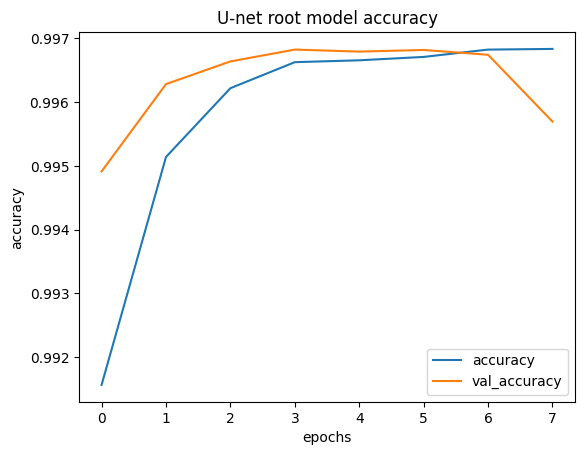

In [11]:
loss_plot(history, "U-net root model loss")
accuracy_plot(history, "U-net root model accuracy")

Predicting all the test images.

In [12]:
predictions = predict_all(images_test, model, patch_size)

4/4 [==============================] - 3s 31ms/step


Visualizing the test images

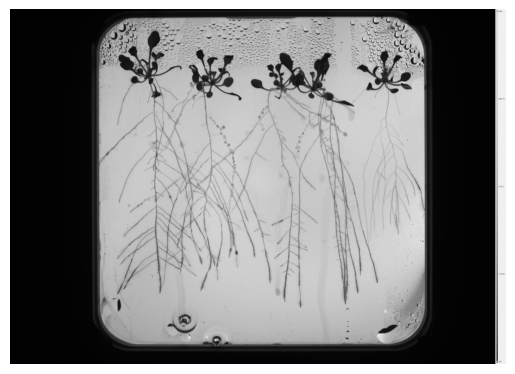

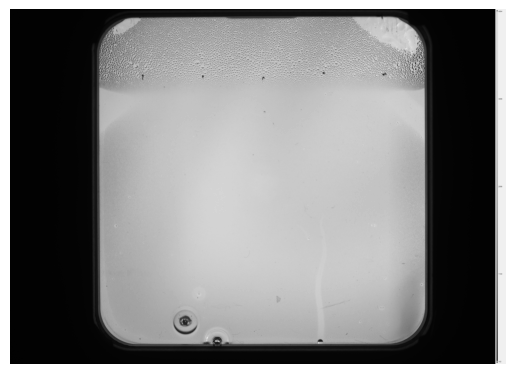

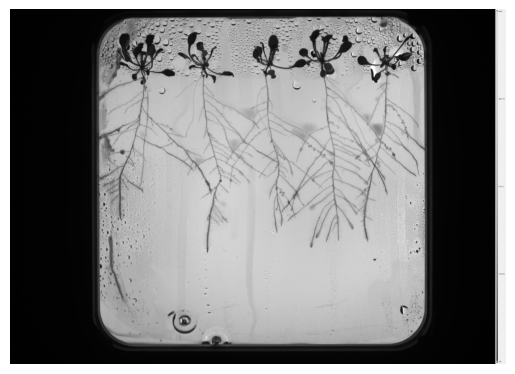

In [13]:
displaying_images(images_test, 3)

Visualizing the test masks

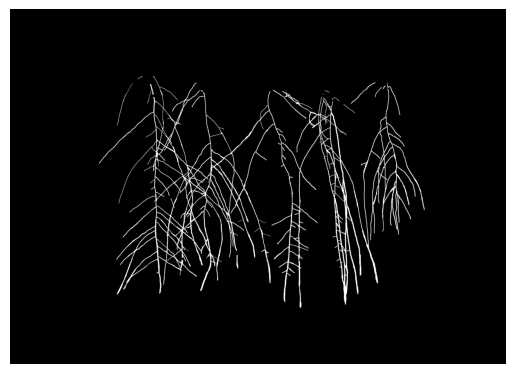

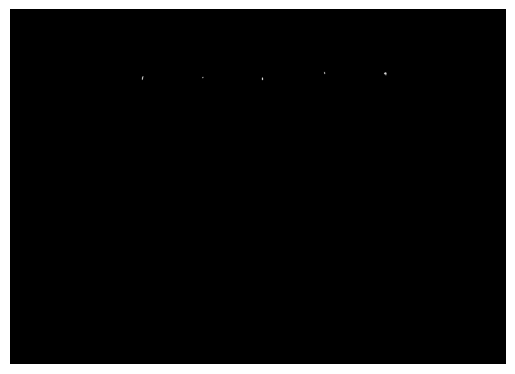

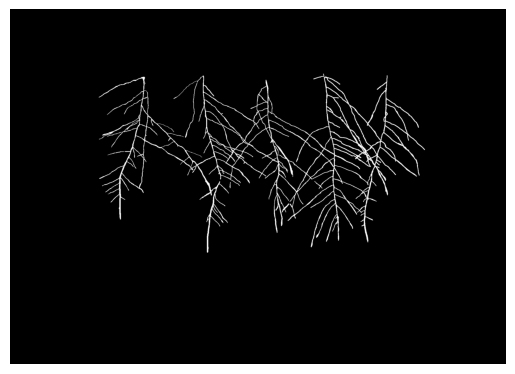

In [14]:
displaying_images(masks_test, 3)

Visualizing the predictions

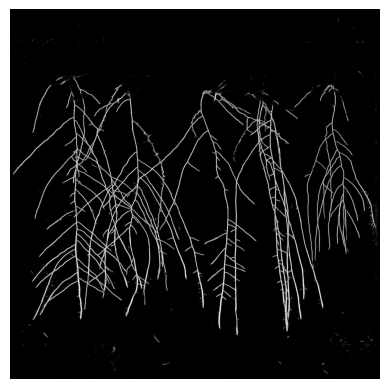

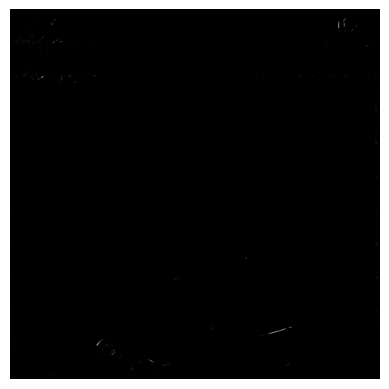

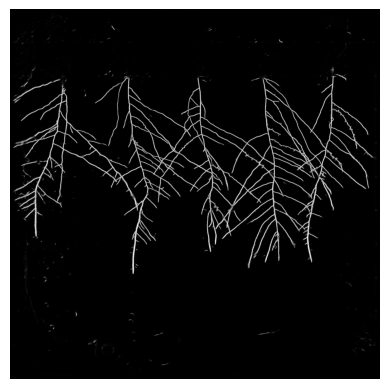

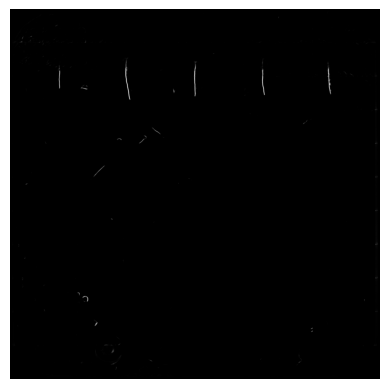

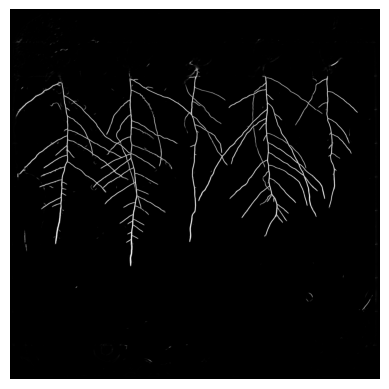

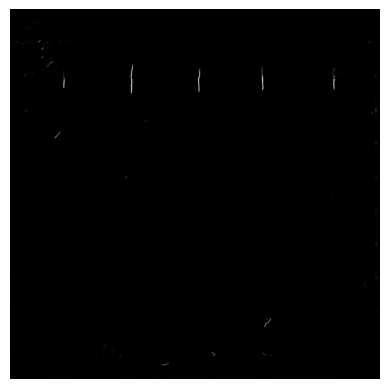

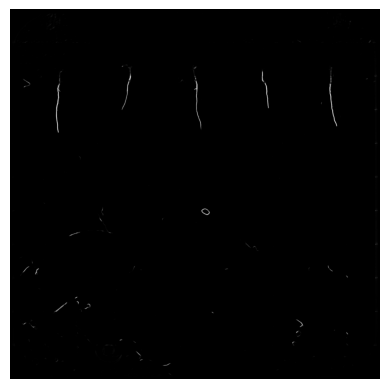

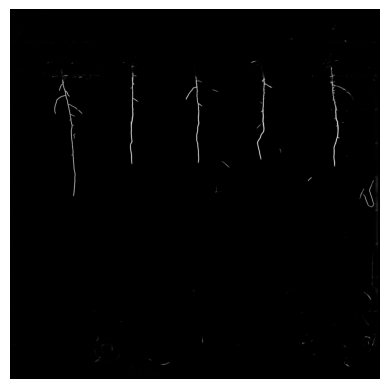

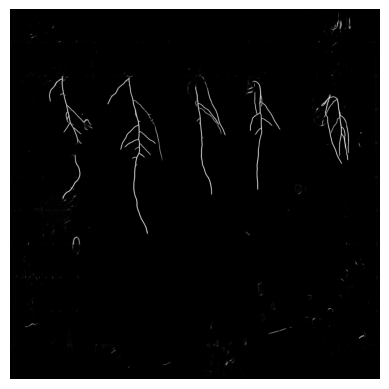

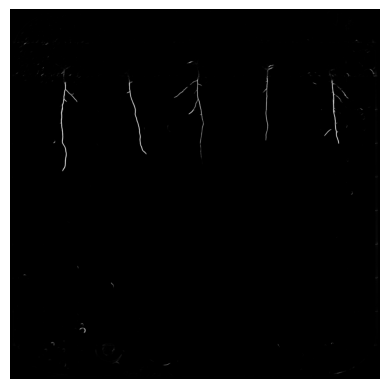

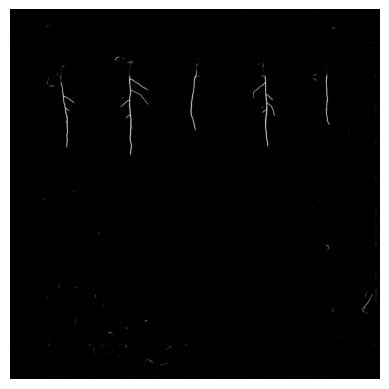

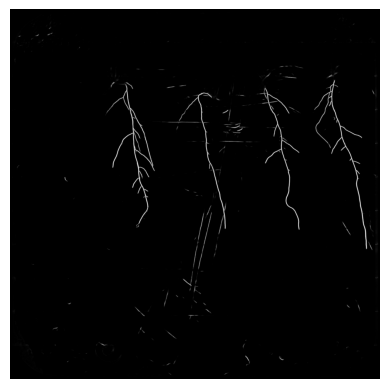

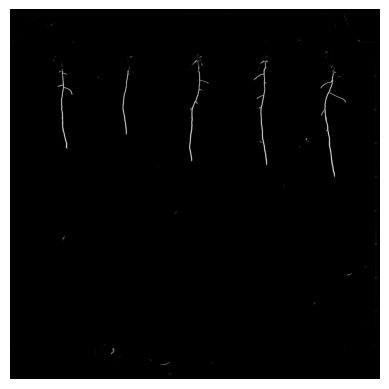

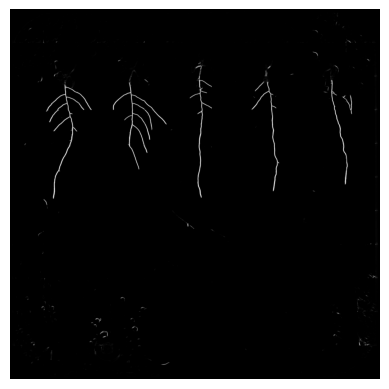

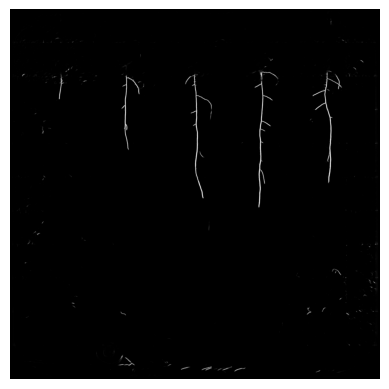

In [15]:
displaying_images(predictions, 15)